In [48]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import time
from numba import njit

In [49]:
@njit
def min_vertical_seam_energy(pixel_energies):
    height, width = pixel_energies.shape
    seam_energies = np.zeros((height, width))
    back_pointers = np.zeros((height, width), dtype=np.int32)

    seam_energies[0] = pixel_energies[0]

    for y in range(1, height):
        for x in range(width):
            x_left = max(x - 1, 0)
            x_right = min(x + 1, width - 1)
            min_parent_x = x_left + np.argmin(seam_energies[y - 1, x_left:x_right + 1])

            seam_energies[y, x] = pixel_energies[y, x] + seam_energies[y - 1, min_parent_x]
            back_pointers[y, x] = min_parent_x

    min_energy = np.min(seam_energies[-1])
    return min_energy

@njit
def find_vertical_seam(pixel_energies):
    height, width = pixel_energies.shape
    seam_energies = np.zeros((height, width))
    back_pointers = np.zeros((height, width), dtype=np.int32)

    seam_energies[0] = pixel_energies[0]

    for y in range(1, height):
        for x in range(width):
            x_left = max(x - 1, 0)
            x_right = min(x + 1, width - 1)
            min_parent_x = x_left + np.argmin(seam_energies[y - 1, x_left:x_right + 1])

            seam_energies[y, x] = pixel_energies[y, x] + seam_energies[y - 1, min_parent_x]
            back_pointers[y, x] = min_parent_x

    min_seam_end_x = np.argmin(seam_energies[-1])
    seam = []

    seam_point_x = min_seam_end_x
    for y in range(height - 1, -1, -1):
        seam.append((seam_point_x, y))
        seam_point_x = back_pointers[y, seam_point_x]

    seam.reverse()
    return seam

def carve_seam(magnitude, phase, seam_path):
    height, width = magnitude.shape
    mask = np.ones((height, width), dtype=bool)
    for x, y in seam_path:
        mask[y, x] = False
    new_magnitude = magnitude[mask].reshape((height, width - 1))
    new_phase = phase[mask].reshape((height, width - 1))
    return new_magnitude, new_phase


def carve_audio(n_of_seams, magnitude, phase, is_vertical=True):
    original_height, original_width = magnitude.shape
    if is_vertical:
        for _ in range(n_of_seams):
            seam_path = find_vertical_seam(magnitude)
            magnitude, phase = carve_seam(magnitude, phase, seam_path)
    else:
        magnitude = np.rot90(magnitude, k=-1)
        phase = np.rot90(phase, k=-1)
        for _ in range(n_of_seams):
            seam_path = find_vertical_seam(magnitude)
            magnitude, phase = carve_seam(magnitude, phase, seam_path)
        magnitude = np.rot90(magnitude, k=1)
        phase = np.rot90(phase, k=1)

        new_height, new_width = magnitude.shape
        if new_height < original_height:
            pad_height = original_height - new_height
            magnitude = np.pad(magnitude, ((0, pad_height), (0, 0)), mode='constant')
            phase = np.pad(phase, ((0, pad_height), (0, 0)), mode='constant')

    return magnitude, phase

In [50]:
# Load in sounds
NJ, srNJ = librosa.load('NewJeansOMG.wav', sr=None, mono=True)
print(srNJ, "sr_flute sampling rate")
D = librosa.stft(NJ)
magnitudeNJ = np.abs(D)
phaseNJ = np.angle(D)
magnitudeNJ = np.array(magnitudeNJ)
phaseNJ = np.array(phaseNJ)
print("shape of magnitude before", magnitudeNJ.shape)
print("shape of phase before", phaseNJ.shape)
print("NJ shape (original): ", NJ.shape)

44100 sr_flute sampling rate
shape of magnitude before (1025, 1332)
shape of phase before (1025, 1332)
NJ shape (original):  (681786,)


In [4]:
n_of_seams = 800
start = time.time()
magnitude, phase = carve_audio(n_of_seams, magnitudeNJ, phaseNJ, is_vertical=True)
end = time.time()
print("shape of magnitude after", magnitude.shape)
print("shape of phase after", phase.shape)
print("The time of execution of above program is :",
      (end-start), "s")
# print("The time of execution of above program is :",
#       (end-start) * 10**3, "ms")

shape of magnitude after (1025, 532)
shape of phase after (1025, 532)
The time of execution of above program is : 4.6526970863342285 s


In [5]:
#horizontal

In [6]:
#NJ, srNJ = librosa.load('NewJeansOMG.wav', sr=None, mono=False)
NJH, srNJH = librosa.load('NewJeansOMG.wav', sr=None, mono=True)
print(srNJ, "sr_flute sampling rate")
D = librosa.stft(NJH)
magnitudeNJH = np.abs(D)
phaseNJH = np.angle(D)
magnitudeNJH = np.array(magnitudeNJH)
phaseNJH = np.array(phaseNJH)
print("shape of magnitude before", magnitudeNJH.shape)
print("shape of phase before", phaseNJH.shape)
print(srNJH)
print("D shape: ", D.shape)
print("NJH shape (original signal): ", NJH.shape)

44100 sr_flute sampling rate
shape of magnitude before (1025, 1332)
shape of phase before (1025, 1332)
44100
D shape:  (1025, 1332)
NJH shape (original signal):  (681786,)


In [8]:
# DONT RUN UNLESS YOU WANT TO DO THE CARVING
n_of_seams = 500
start = time.time()
magnitude1, phase1 = carve_audio(n_of_seams, magnitudeNJH, phaseNJH, is_vertical=False)
end = time.time()
print("shape of magnitude after", magnitude1.shape)
print("shape of phase after", phase1.shape)
print("The time of execution of above program is :",
      (end-start), "s")

shape of magnitude after (1025, 1332)
shape of phase after (1025, 1332)
The time of execution of above program is : 2.8804280757904053 s


In [36]:
#trying power p=amp^2

(1025, 1332)
(1025, 1332)


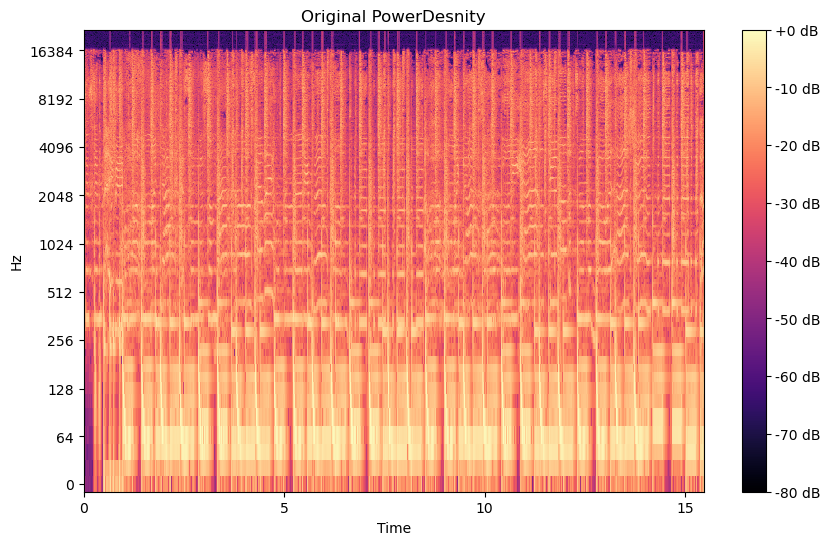

In [37]:
print(magnitudeNJH.shape)
powerNJH = np.abs(magnitudeNJH)
print(powerNJH.shape)
# Calculate spectrogram for original data
D_db = librosa.power_to_db(powerNJH, ref=np.max)
plt.figure(figsize=(10, 6))
librosa.display.specshow(D_db, sr=srNJH, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Original PowerDesnity')

# Get axis limits of the first plot
xmin, xmax, ymin, ymax = plt.axis()

plt.show()

In [40]:
n_of_seams = 500
start = time.time()
magnitude1, phase1 = carve_audio(n_of_seams, powerNJH, phaseNJH, is_vertical=False)
end = time.time()
print("shape of magnitude after", magnitude1.shape)
print("shape of phase after", phase1.shape)
print("The time of execution of above program is :",
      (end-start), "s")

shape of magnitude after (1025, 1332)
shape of phase after (1025, 1332)
The time of execution of above program is : 2.9058260917663574 s


complex_spectrogram_vertical shape:  (1025, 1332)
reconstructed_signal_vertical shape:  (681472,)


Text(0.5, 1.0, 'Original PowerDesnity')

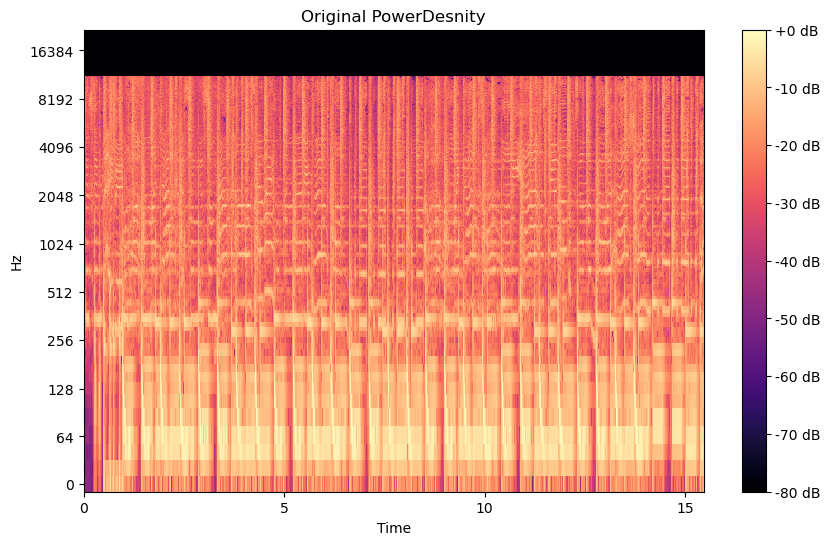

In [41]:
power_to_amp = np.sqrt(magnitude1)
# Reconstruct the complex spectrogram
complex_spectrogram_vertical = power_to_amp * np.exp(1j * phase1)

reconstructed_signal_vertical = librosa.istft(complex_spectrogram_vertical) #ISSUE HERE CHANGES TO MONO

output_filename = f'NewJeansOMG_horizontalPOWER{n_of_seams}.wav'

# Write the reconstructed audio signal to a file using soundfile
sf.write(output_filename, reconstructed_signal_vertical, srNJ) #OR HERE CHANGES TO MONO
print("complex_spectrogram_vertical shape: ", complex_spectrogram_vertical.shape)
print("reconstructed_signal_vertical shape: ", reconstructed_signal_vertical.shape)

# Calculate spectrogram for original data
D_db = librosa.power_to_db(magnitude1, ref=np.max)
plt.figure(figsize=(10, 6))
librosa.display.specshow(D_db, sr=srNJH, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Original PowerDesnity')

(1025, 1332)
(1025, 1332)


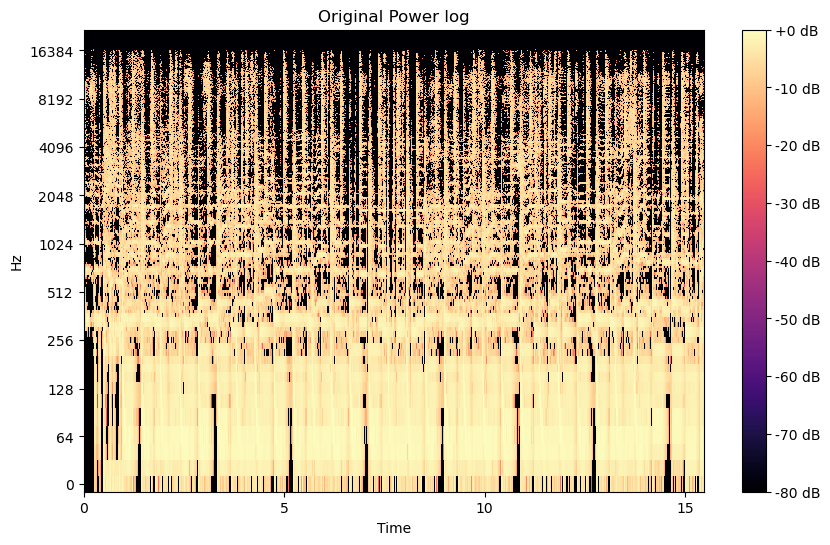

In [51]:
print(magnitudeNJH.shape)
powerNJHlog = np.log(magnitudeNJH)
print(powerNJHlog.shape)
# Calculate spectrogram for original data
D_db = librosa.power_to_db(powerNJHlog, ref=np.max)
plt.figure(figsize=(10, 6))
librosa.display.specshow(D_db, sr=srNJH, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Original Power log')

# Get axis limits of the first plot
xmin, xmax, ymin, ymax = plt.axis()

plt.show()

In [52]:
n_of_seams = 400
start = time.time()
magnitude1, phase1 = carve_audio(n_of_seams, powerNJHlog, phaseNJH, is_vertical=False)
end = time.time()
print("shape of magnitude after", magnitude1.shape)
print("shape of phase after", phase1.shape)
print("The time of execution of above program is :",
      (end-start), "s")

shape of magnitude after (1025, 1332)
shape of phase after (1025, 1332)
The time of execution of above program is : 2.6318671703338623 s


In [55]:
powerlog_to_amp = np.log(np.exp(magnitude1))
# Reconstruct the complex spectrogram
complex_spectrogram_vertical = powerlog_to_amp * np.exp(1j * phase1)

reconstructed_signal_vertical = librosa.istft(complex_spectrogram_vertical)

output_filename = f'NewJeansOMG_horizontalPOWERLOG{n_of_seams}.wav'

# Write the reconstructed audio signal to a file using soundfile
sf.write(output_filename, reconstructed_signal_vertical, srNJ) #OR HERE CHANGES TO MONO
print("complex_spectrogram_vertical shape: ", complex_spectrogram_vertical.shape)
print("reconstructed_signal_vertical shape: ", reconstructed_signal_vertical.shape)

complex_spectrogram_vertical shape:  (1025, 1332)
reconstructed_signal_vertical shape:  (681472,)


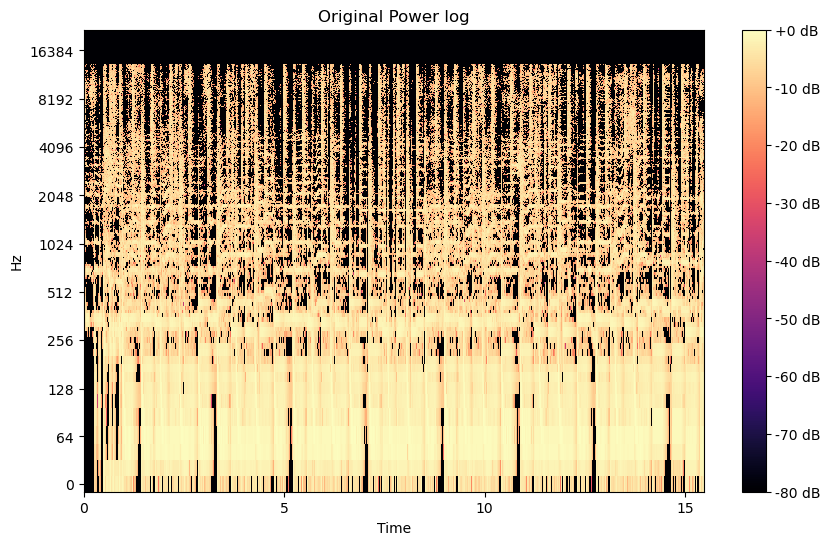

In [54]:
# Calculate spectrogram for original data
D_db = librosa.power_to_db(magnitude1, ref=np.max)
plt.figure(figsize=(10, 6))
librosa.display.specshow(D_db, sr=srNJH, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Original Power log')

# Get axis limits of the first plot
xmin, xmax, ymin, ymax = plt.axis()

plt.show()